In [1]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt

In [3]:
def retrieveData():
    data = list(csv.reader(open('test1.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

def retrievePreviousData():
    data = list(csv.reader(open('prevTour.csv')))
    return data


In [4]:
class ACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            exploration = random.uniform(0.0,1.0)
            if exploration < 0.10: #randomly explore
                min = float("inf")
                for unvisited_node in unvisited_nodes:
                    if self.edges[self.tour[-1]][unvisited_node].weight < min:
                        min = self.edges[self.tour[-1]][unvisited_node].weight
                        min_node = unvisited_node
                explored_node = min_node
                return explored_node
            else:
                roulette_wheel = 0.0
                for unvisited_node in unvisited_nodes: 
                    roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                      pow((1.0 / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                random_value = random.uniform(0.0, 1.0)
                wheel_position = 0.0
                for unvisited_node in random.sample(unvisited_nodes,len(unvisited_nodes)):
                    wheel_position += (pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                      pow((1.0 / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)) / roulette_wheel
                    if wheel_position >= random_value:
                        return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, jump_pheromone=1.5, steps=100, nodes=None, labels=None, previous_path=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        if previous_path != None:
            for i in range(len(previous_path)):
                if (previous_path[i-1] in labels) and (previous_path[i] in labels):
                    for j in range(len(labels)): #find index-1
                        if previous_path[i-1] == labels[j]:
                            for k in range(len(labels)):#find index-2
                                if previous_path[i] == labels[k]:
                                    self.edges[j][k].pheromone = jump_pheromone
                                    self.edges[k][j].pheromone = jump_pheromone
        
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _elitist_acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def run(self):
        self._elitist_acs()
        print('Route Sequence: {0} '.format(','.join(str(self.labels[i]) for i in self.global_best_tour)),'\n')
        csv_str = [self.labels[i] for i in self.global_best_tour]
        with open("prevTour.csv",'w') as resultFile:
            wr = csv.writer(resultFile, dialect='excel')
            wr.writerow(csv_str)
        print('Distance of tour: {0}\n'.format(round(self.global_best_distance, 2)))

    def sketch(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        fig, ax = plt.subplots()
        ax.imshow(img, extent=[-455, 705, -455, 405])
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()

Route Sequence:  F, [, C, T, c, Q, G, H, S, m, ~, W, l, |, ^, Y, o, A, b, q, n, K, {, J, \, i, N, O, I, L, w, v, U, x, j, z, D, ], e, V, }, X, r, u, `, p, _, a, R, P, Z, t, s, h, y, E, f, B, k, M, g, d  

Distance of tour: 5768.58



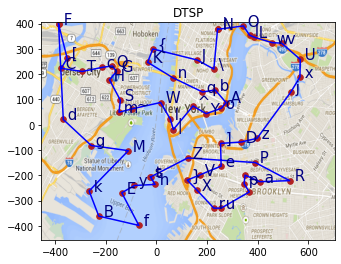

<Figure size 432x288 with 0 Axes>

In [5]:
if __name__ == '__main__':
    coordinates, places = retrieveData()
    previous_data = retrievePreviousData()
    _colony_size = 20
    _steps = 350
    _nodes = coordinates
    elitist_instance = ACO(mode='DTSP', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places, previous_path=previous_data)
    elitist_instance.run()
    elitist_instance.sketch()

In [6]:
import csv
data = list(csv.reader(open('datafile.csv')))
for i in data:
    i[0] = float(i[0])
    i[1] = float(i[1])
lattitude = [i[0] for i in data]
longitude = [i[1] for i in data]
coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
places = [i[2] for i in data]
print (data)
print('lattitude: ', lattitude)
print('longitude: ', longitude)
print('coordinates: ', coordinates)
print('places: ', places)

[[300.0, 200.0, 'Office'], [-300.0, 150.0, 'Plant'], [-200.0, 300.0, 'Home'], [20.0, -350.0, 'Park'], [-25.0, 220.0, 'Garage'], [25.0, 84.0, 'Work'], [210.0, -97.0, 'Factory'], [215.0, 34.0, 'A'], [3.0, 45.0, 'B'], [-350.0, -350.0, 'C'], [78.8082523072, -277.584758819, ' a'], [-241.860995569, 240.378896381, ' b'], [323.343785709, 37.0648945699, ' c'], [36.304777219, -388.104545099, ' d'], [220.411659417, 89.4733712635, ' e']]
lattitude:  [300.0, -300.0, -200.0, 20.0, -25.0, 25.0, 210.0, 215.0, 3.0, -350.0, 78.8082523072, -241.860995569, 323.343785709, 36.304777219, 220.411659417]
longitude:  [200.0, 150.0, 300.0, -350.0, 220.0, 84.0, -97.0, 34.0, 45.0, -350.0, -277.584758819, 240.378896381, 37.0648945699, -388.104545099, 89.4733712635]
coordinates:  [[300.0, 200.0], [-300.0, 150.0], [-200.0, 300.0], [20.0, -350.0], [-25.0, 220.0], [25.0, 84.0], [210.0, -97.0], [215.0, 34.0], [3.0, 45.0], [-350.0, -350.0], [78.8082523072, -277.584758819], [-241.860995569, 240.378896381], [323.343785709,

In [8]:
#Create Data Points (coordinates and locations)
import random 
A=400*random.random()

for i in range(62):
    print (random.uniform(-400, 600),',', random.uniform(-400, 400),',', chr(65+i))

118.42811345299981 , -352.95644596864474 , A
339.83761018800624 , 31.135445403910353 , B
113.95187480782374 , -120.45449441020628 , C
122.78578380855765 , -21.212137074260113 , D
357.5559787944385 , -259.03386506718425 , E
-281.9391041293657 , 46.6184553888981 , F
-356.54999319927117 , -266.9317891324773 , G
-138.68972147081303 , -116.82763660113062 , H
430.3053867828813 , 13.610162347612516 , I
526.9186339575759 , 103.7752628043907 , J
575.4805854705702 , 103.24902818826178 , K
-131.4270343653879 , 144.03717558799633 , L
201.17907898115664 , -271.9431536588876 , M
371.1757144615856 , 108.18080708467176 , N
493.71303519192975 , 78.02079718687969 , O
-196.1227730117183 , -335.02594204490396 , P
-109.49198705981473 , 112.17177833189385 , Q
-52.84738389668087 , 235.51113270440385 , R
-25.389331202018695 , -202.10390746841043 , S
506.17295237770406 , -245.7050181181229 , T
128.96372620596867 , -290.0066135601144 , U
-384.09417745633385 , 317.5267513298055 , V
187.09368676523275 , 371.87649

In [9]:
#Create Data Points (coordinates and locations)
import random 
A=400*random.random()

for i in range(62):
    print (random.uniform(-400, 600),',', random.uniform(-400, 400),',', chr(65+i))

337.83505143025263 , 143.49589708808946 , A
-392.4826019033124 , -339.16377434243327 , B
-287.92248850691044 , -228.93186449523873 , C
-324.065183171864 , 347.8059900802032 , D
152.1804759555539 , -22.485851810553356 , E
511.1594915307418 , 199.03302967782668 , F
-23.484663072745775 , 368.9870393341539 , G
83.09058792710869 , 337.4383381196667 , H
28.395333433308735 , -275.92616787584495 , I
29.330145031861093 , 392.3146445612442 , J
122.93009404237978 , -133.2671909516427 , K
-138.2450068156382 , -267.56734724107974 , L
0.3991370052383445 , -93.88236135065097 , M
165.19606099293753 , 28.743393253033048 , N
-171.27090509472728 , 12.099632394926402 , O
435.8035770949872 , -306.5759108905637 , P
-371.75741390770764 , 222.87194991842682 , Q
-347.85934332488154 , 168.62169329769597 , R
371.75713118908095 , 123.21939088620081 , S
296.4313243922469 , -227.7229863961665 , T
587.5334732069201 , 206.07744990629828 , U
229.84103431050744 , 341.4680451560125 , V
-185.5401558357743 , -52.471734914

In [12]:
#Create Data Points (coordinates and locations)


import csv
import random 
count = 62
random_coordinates = [[] for i in range(count)]
for i in range(count):
    random_coordinates[i].append(random.uniform(-400, 600))
    random_coordinates[i].append(random.uniform(-400, 400))
    random_coordinates[i].append(chr(65+i))
    print(random_coordinates[i])

with open('test2.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(random_coordinates)
count = 0

[243.38222678275224, -371.0561509070607, 'A']
[-292.2283321914527, 281.7427148471578, 'B']
[-316.68963338839103, -42.81138772916728, 'C']
[592.9183841783973, -90.38581529038697, 'D']
[128.96914752647842, 66.03960514431708, 'E']
[-262.139720067853, 18.03103989289292, 'F']
[39.1953211101727, -24.43503709315047, 'G']
[61.93977119570752, 98.74604840298434, 'H']
[80.5931463183394, 99.123152133833, 'I']
[389.60085072276684, 345.6873461717032, 'J']
[-45.36436707848634, 264.7094914705383, 'K']
[-133.3045339009082, 333.8370095960246, 'L']
[579.4600423496873, -279.9034380210978, 'M']
[468.23083483685537, -176.2616670447259, 'N']
[464.4572256737441, 369.01515050912167, 'O']
[-360.7705955891545, -179.4126231306576, 'P']
[-141.41906813439005, 225.0762340876321, 'Q']
[-391.4653243996513, -296.40544716287195, 'R']
[411.521074554185, -101.75780276328732, 'S']
[-54.043083277200594, -224.6310779781595, 'T']
[414.9422278177635, 77.70859022872418, 'U']
[568.0133273585282, 227.69313415804447, 'V']
[521.814

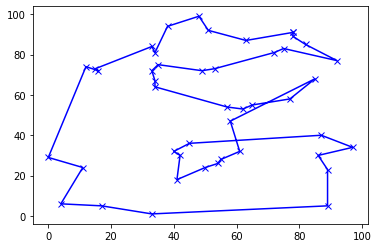

In [18]:
import random, numpy, math, copy, matplotlib.pyplot as plt
cities = [random.sample(range(100), 2) for x in range(45)];
tour = random.sample(range(45),45);
for temperature in numpy.logspace(0,5,num=100000)[::-1]:
    [i,j] = sorted(random.sample(range(45),2));
    newTour =  tour[:i] + tour[j:j+1] +  tour[i+1:j] + tour[i:i+1] + tour[j+1:];
    if math.exp( ( sum([ math.sqrt(sum([(cities[tour[(k+1) % 45]][d] - cities[tour[k % 45]][d])**2 for d in [0,1] ])) for k in [j,j-1,i,i-1]]) - sum([math.sqrt(sum([(cities[newTour[(k+1) % 45]][d] - cities[newTour[k % 45]][d])**2 for d in [0,1] ])) for k in [j,j-1,i,i-1]])) / temperature) > random.random():
        tour = copy.copy(newTour);
plt.plot(list(zip(*[cities[tour[i % 45]] for i in range(46) ]))[0], list(zip(*[cities[tour[i % 45]] for i in range(46) ]))[1], 'xb-', );
plt.show()